In [71]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
class Signal:

    def __init__(self) -> None:
        pass

    def signal_initialize(self, amplitude, frequency, reprtition, n_points, duty_cycle):
        self.amplitude = amplitude
        self.frequency = frequency
        self.reprtition = reprtition
        self.n_points = n_points
        self.duty_cycle = duty_cycle
        self.period = 1 / frequency
        self.time_array = np.linspace(0, self.reprtition * self.period, self.reprtition * self.n_points)

    def sine(self) -> list:
        scale = 2 * np.pi * self.frequency
        voltage = self.amplitude * np.sin(self.time_array * scale)
        self.V = np.array(voltage)
        return [self.time_array, self.V]
    
    def triangle(self):
        quater_period = self.period / 4
        time_array = np.linspace(0, self.reprtition * self.period, self.reprtition * self.n_points)
        voltage = []
        for i in range(len(time_array)):
            if time_array[i] <= quater_period:
                voltage.append(self.amplitude / quater_period * (time_array[i]))
            elif (time_array[i] > quater_period) and (time_array[i] < 3 * quater_period):
                voltage.append(- self.amplitude / quater_period * (time_array[i] - quater_period) + self.amplitude)
            else:
                voltage.append(self.amplitude / quater_period * (time_array[i] - 3 * quater_period) - self.amplitude)
        self.V = np.array(voltage)
        return [self.time_array, self.V]
    
    def bipolar_rectangle(self):
        half_period = self.period / 2
        voltage = []
        for i in range(len(self.time_array)):
            if self.time_array[i] <= half_period * (1 - 2 *  self.duty_cycle):
                voltage.append(0)
            elif (self.time_array[i] > half_period * (1 - 2 *  self.duty_cycle)) and (self.time_array[i] < half_period):
                voltage.append(self.amplitude)
            elif (self.time_array[i] >= half_period) and (self.time_array[i] < 2 * half_period * (1 - self.duty_cycle)):
                voltage.append(0)
            else:
                voltage.append(-self.amplitude)
        voltage[-1] = 0
        self.V = np.array(voltage)
        return [self.time_array, self.V]



In [73]:
class Hyperparameters:

    def __init__(self) -> None:
        pass

    def hyp_initialize(self, V_th, a, b, c, s, n, beta, xi, alpha_m, gamma):
        self.V_th = V_th
        self.a = a
        self.b = b
        self.c = c
        self.s = s
        self.n = n
        self.beta = beta
        self.xi = xi
        self.alpha_m = alpha_m
        self.gamma = gamma

In [74]:
class Calculation:

    def __init__(self) -> None:
        pass
    
    def p_calc(self, V_i):
        return int(self.b/(np.abs(V_i) + self.c))

    def f_calc(self, x_i, V_i):
        if V_i <= - self.V_th:
            return 1 - (1 - x_i) ** (self.p_calc(V_i))
        elif V_i >= self.V_th:
            return 1 - x_i ** (self.p_calc(V_i))
        else:
            return 0
        
    def x_calc(self):
        delta_t = self.time_array[1] - self.time_array[0]
        x = [0]
        for i in range(1, len(self.time_array)):
            x.append(self.a * self.V[i-1] ** self.s * self.f_calc(x[i-1], self.V[i-1]) * delta_t + x[i-1])
        return np.array(x)

    def current_calc(self):
        x = self.x_calc()
        return x ** self.n * self.beta * np.sinh(self.alpha_m * self.V) + self.xi * (np.exp(self.gamma * self.V) - 1)

In [75]:
class Model(Signal, Hyperparameters, Calculation):

    def __init__(self) -> None:
        super().__init__()

    def set_puls_params(self, amplitude = 2, frequency = 1, reprtition = 1, n_points = 100, duty_cycle = 0.25):
        super().signal_initialize(amplitude= amplitude, frequency= frequency, reprtition = reprtition, n_points = n_points, duty_cycle = duty_cycle)

    def set_hyperparams(self, V_th  = 1.3, a= 1 , b = 15, c = 2, s = 5, n = 5, beta = 7.069 * 10 ** (-5), xi = 1.946 * 10 ** (-4), alpha_m = 1.8, gamma = 0.15):
        super().hyp_initialize(V_th = V_th, a = a, b = b, c = c, s = s, n = n, beta = beta, xi = xi, alpha_m = alpha_m, gamma = gamma)
        
    def set_puls_form(self, puls_type = 'sine'):
        match puls_type:
            case 'sine':
                self.t, self.V = super().sine()
            case 'triangle':
                self.t, self.V = super().triangle()
            case 'rectangle':
                self.t, self.V = super().bipolar_rectangle()
            case _:
                self.t, self.V = super().sine()
                print('The pulse type is\'t set correctly. The default pulse type value is set')

    def set_default(self):
        self.set_hyperparams()
        self.set_puls_params()
        self.set_puls_form()

    def calculate(self):
        self.I = super().current_calc()



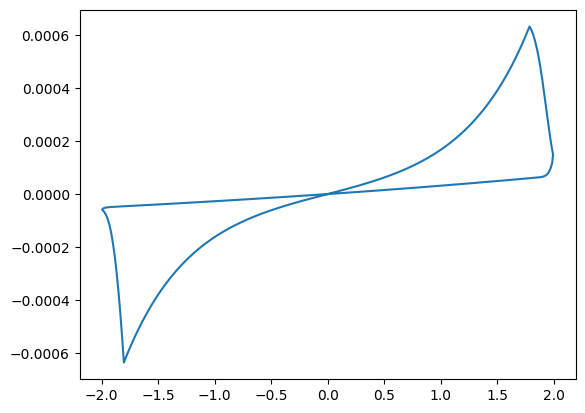

In [78]:
m = Model()

m.set_hyperparams(V_th=1.8)
m.set_puls_params(amplitude=2, n_points=500)
m.set_puls_form(puls_type='triangle')
m.calculate()
t = m.time_array
V = m.V
I = m.I

plt.plot(V, I)